# Advanced Data Science with IBM
## Use Case: Fault prediction for gear bearings (anomaly detection)

### 1. Modeling - Preparation
In this notebook the models will be created.  
In the first chapter of this notebook I will import 2 csv files which I have prepared in the ETL notebook:
1. df_ok.csv: IoT measure points of bearings without anomalies and without bearing failures. This measure points will be used to train the networks
2. df_nok.csv: IoT measure points of bearing with failure. With this data set we will see how our algorithms for detecting anomalies perform


In [53]:
#All import statements
import numpy as np
import pandas as pd
import os, csv, glob, datetime, time
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras import regularizers
#from keras.callbacks import Callback
from keras.layers import LSTM, Dense
from matplotlib.dates import DateFormatter

#install pyod for knn outlier detection
!pip install pyod
from pyod.models.knn import KNN   # kNN detector

#to get rid of the warning execute register_matplotlib_converters() 
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from botocore.client import Config
import ibm_boto3
%matplotlib inline

In [54]:
# import the training data without bearing failure
def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share your notebook.
client_b2d04bb960e541b59bf748286f30fef3 = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='HXB6bIyaokBGw-eWQ7IlD3GvZyZhVYDCePt5uiSYMZnq',
    ibm_auth_endpoint="https://iam.bluemix.net/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3-api.us-geo.objectstorage.service.networklayer.com')

body = client_b2d04bb960e541b59bf748286f30fef3.get_object(Bucket='courseraadvanceddatascience-donotdelete-pr-eqpoqlvyxje0ta',Key='df_nok.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_nok = pd.read_csv(body)
df_nok.index = pd.DatetimeIndex(df_nok.date)
df_nok = df_nok.drop(['date'], axis=1)

In [55]:
#Import test data which contains the bearing failures
body = client_b2d04bb960e541b59bf748286f30fef3.get_object(Bucket='courseraadvanceddatascience-donotdelete-pr-eqpoqlvyxje0ta',Key='df_ok.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_ok = pd.read_csv(body)
df_ok.index = pd.DatetimeIndex(df_ok.date)
df_ok = df_ok.drop(['date'], axis=1)

In [56]:
#get overview about the data
df_ok.head()

,bearing1,bearing2,bearing3,bearing4
date,,,,
2004-02-12 10:40:00,0.127896,0.457060,0.556003,0.365093
2004-02-12 10:50:00,0.130644,0.458403,0.552573,0.364258
2004-02-12 11:00:00,0.133330,0.456029,0.556160,0.369705
2004-02-12 11:10:00,0.133125,0.467033,0.545364,0.370022
2004-02-12 11:20:00,0.133806,0.452518,0.558971,0.361946


In [57]:
#get overview about the data
df_ok.describe()

,bearing1,bearing2,bearing3,bearing4
count,224.000000,224.000000,224.000000,224.000000
mean,0.132014,0.466941,0.525509,0.361078
std,0.001858,0.004504,0.011830,0.004477
min,0.127639,0.452518,0.499072,0.350592
25%,0.130690,0.464006,0.517033,0.358072
50%,0.131935,0.467231,0.524785,0.361095
75%,0.133341,0.469910,0.533294,0.364009
max,0.137210,0.480742,0.558971,0.374626


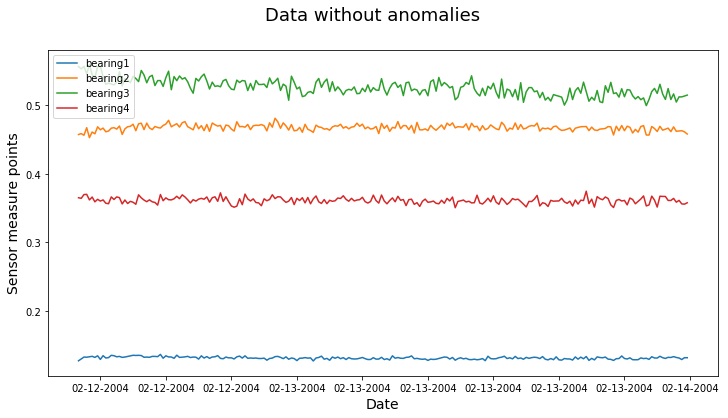

In [58]:
#plot the data without anomalies

# Define the date format
myFmt = DateFormatter('%m-%d-20%y') 

fig, ax = plt.subplots(figsize = (12,6))
ax.plot(df_ok.bearing1)
ax.plot(df_ok.bearing2)
ax.plot(df_ok.bearing3)
ax.plot(df_ok.bearing4)
ax.xaxis.set_major_formatter(myFmt)
fig.suptitle('Data without anomalies', fontsize=18)
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Sensor measure points', fontsize=14)
ax.legend(loc="upper left")

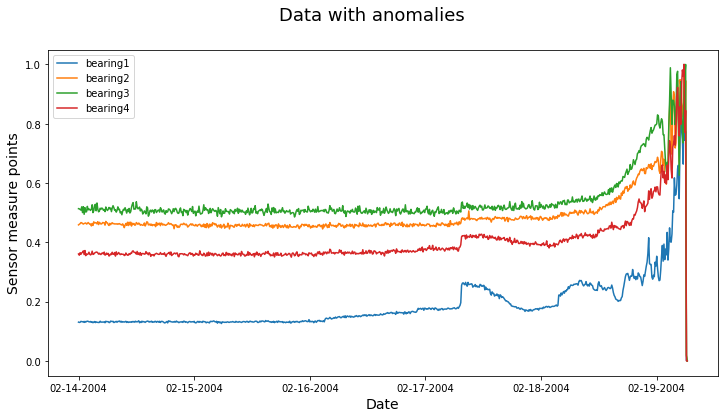

In [59]:
#plot the data with anomalies

# Define the date format
myFmt = DateFormatter('%m-%d-20%y') 

fig, ax = plt.subplots(figsize = (12,6))
ax.plot(df_nok.bearing1)
ax.plot(df_nok.bearing2)
ax.plot(df_nok.bearing3)
ax.plot(df_nok.bearing4)
ax.xaxis.set_major_formatter(myFmt)
fig.suptitle('Data with anomalies', fontsize=18)
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Sensor measure points', fontsize=14)
ax.legend(loc="upper left")

In above picture we can clearly see the bearings failure

### 2. Modeling
I prepared 3 models to detect the bearings failure as soon as possible:
1. NN: Deep Learning Autoencoder with LSTM Layer
2. NN: Deep Learning Autoencoder with Dense Layer
3. KNN Classification

Why I have chosen an LSTM Network:
* In oppostion to e.g. Recurrent Networks, LSTM Networks have the advantage to remember things over long durations of time. To be able to to this, LSTM maintains a cell state as well as a carry for ensuring that the signal is not lost as the sequence is processed
* LSTM networks are used to overcome the issue with Vanishing Gradience

#### Model 1 - NN: Deep Learning Autoencoder with LSTM Layer

In [60]:
#reshape the dataframe according to the LSTM input shape
def reshape_lstm(df,timesteps,dim=4):
    #df: dataframe
    #timesteps: int with number of timesteps
    #dim: int with number ot timesteps
    
    arr = np.array(df)
    samples=len(arr)
    trim = samples %  timesteps
    reshaped = arr[:samples-trim]
    reshaped.shape = (int((samples-trim)/timesteps),timesteps,dim)
    return reshaped

In [61]:
# Modeling - design LSTM network
def create_lstm(timesteps=10, dim=4):
    model = Sequential()
    model.add(LSTM(50,input_shape=(timesteps,dim),return_sequences=True))
    model.add(LSTM(50,return_sequences=True))
    model.add(LSTM(50,return_sequences=True))
    model.add(Dense(4))
    model.compile(loss='mae', optimizer='adam')
    return model

In [62]:
# reshape the data for LSTM model
lstm_ok = reshape_lstm(df_ok,10,dim=4)
lstm_nok = reshape_lstm(df_nok,10,dim=4)

In [63]:
# test if shape is OK for LSTM
lstm_ok.shape

(22, 10, 4)

In [64]:
# create LSTM model
lstm_model = create_lstm()

In [65]:
#details about the number of parameters and output shapes of each layer and an overall model structure
lstm_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 10, 50)            11000     
_________________________________________________________________
lstm_8 (LSTM)                (None, 10, 50)            20200     
_________________________________________________________________
lstm_9 (LSTM)                (None, 10, 50)            20200     
_________________________________________________________________
dense_16 (Dense)             (None, 10, 4)             204       
Total params: 51,604
Trainable params: 51,604
Non-trainable params: 0
_________________________________________________________________


#### Model 2 -  Deep Learning Autoencoder with Dense Layer

In [66]:
# Modeling - design neural network
def create_model_NN(df):
    act_func = 'elu'
    model = Sequential()
    model.add(Dense(10,activation=act_func,
                    kernel_initializer='glorot_uniform',
                    kernel_regularizer=regularizers.l2(0.0),
                    input_shape=(df.shape[1],)))
    model.add(Dense(2,activation=act_func, kernel_initializer='glorot_uniform'))
    model.add(Dense(10,activation=act_func, kernel_initializer='glorot_uniform'))
    model.add(Dense(df.shape[1], kernel_initializer='glorot_uniform'))

    model.compile(loss='mse', optimizer='adam')
    return model

In [67]:
#create the model
dense_model = create_model_NN(df_ok)

#### Model 3 -  KNN

In [68]:
# create kNN detector
#Following coding will be executed in the training and evaluation notebeook
#knn_model = KNN(n_neighbors=20, method='median')

### 3. Save models

In [69]:
# save model and architecture to single file
lstm_model.save("lstm_model.h5")
dense_model.save("dense_model.h5")
# knn model will not be saved because of issues with pyod
print('Saving done')

Saving done
